In [1]:
#imports 
import tensorflow as tf
import abc
import tensorflow_addons as tfa
import numpy as np
from sklearn.model_selection import train_test_split
import time
import pandas as pd
import random
from sklearn.metrics import f1_score, accuracy_score
import matplotlib.pyplot as plt

In [2]:
def create_train_test_x_y(num_words):
    (X, y), (x_test, y_test) = tf.keras.datasets.reuters.load_data(num_words=num_words, test_split = 0)
    dataset_df = pd.DataFrame(columns=['x', 'y']) 
    dataset_df['x'] = X
    dataset_df['y'] = y
    top_classes = dataset_df['y'].value_counts()[:10].index.tolist()
    dataset_df = dataset_df[dataset_df['y'].isin(top_classes)].reset_index(drop=True)
    map_dict = dict(zip(top_classes, list(range(10))))
    dataset_df['y'] = dataset_df['y'].map(map_dict)
    x_train, x_test, y_train, y_test = train_test_split(dataset_df['x'], dataset_df['y'], test_size=0.2, random_state=42)
    return x_train, x_test, y_train, y_test


In [3]:
def create_ds(X, y, max_length=64, batch_size=100):
    X = tf.keras.preprocessing.sequence.pad_sequences(X, padding='post', maxlen=max_length)
    dataset = tf.data.Dataset.from_tensor_slices((X, y)) 
    dataset = dataset.shuffle(buffer_size=len(X)).batch(batch_size=batch_size)
    return dataset

x_train, x_test, y_train, y_test = create_train_test_x_y(2000)
train_ds = create_ds(x_train,y_train)
test_ds = create_ds(x_test,y_test)

2113536/2110848 [==============================] - 0s 0us/step


In [4]:
class WordEmbeddingLayer(tf.keras.layers.Layer):

    def __init__(self, words_len, embed_size):
        super(WordEmbeddingLayer, self).__init__()
        self.words_len = words_len
        self.embed_size = embed_size   
        self.embeddings = tf.Variable(tf.random.uniform([self.words_len, self.embed_size]))
        
    def __call__(self, inputs):   
        return tf.nn.embedding_lookup(self.embeddings, inputs)

In [5]:
class RNNModel(tf.keras.Model):
    def __init__(self, words_len=2000, embed_size=500, hidden_size=10):
        super(RNNModel, self).__init__()
        self.hidden_size = hidden_size
        self.embed_size = embed_size
        self.words_len = words_len + 1
        self.emmbedding = tf.keras.layers.Embedding(self.words_len, self.embed_size)
        self.dense = tf.keras.layers.Dense(units=10, activation='softmax')
        self.w = self.add_weight(shape=(self.hidden_size, self.hidden_size + self.embed_size), 
                                 initializer='truncated_normal', trainable=True)
        self.b = self.add_weight(shape=(self.hidden_size,1), initializer='truncated_normal', trainable=True) 

    
        
    def rnn(self, x_i, h_prev):
        x_t = tf.transpose(x_i)
        input_and_state_concatenated = tf.concat([x_t, h_prev],0)
        return tf.tanh(tf.matmul(self.w, input_and_state_concatenated) + self.b)

    def call(self, inputs, training=False):
        x = self.emmbedding(inputs)
        h = tf.zeros(shape=(self.hidden_size, len(x)))
        for i in range(x.shape[1]):
            h = self.rnn(x[:, i], h)

        return self.dense(tf.transpose(h))

    def fit(self, **kwargs):
        self.epoch_loss_train = []
        self.epoch_f1_train = []
        self.epoch_acc_train = []
        self.epoch_loss_test = []
        self.epoch_f1_test = []
        self.epoch_acc_test = []
        train_ds = kwargs.get("train_ds", None)
        test_ds = kwargs.get("test_ds", None)
        batch_size = kwargs.get("batch_size", 100)
        lr = kwargs.get("lr", 0.001)
        epoch_num = kwargs.get("epoch_num", 10)
        optimizer = kwargs.get("optimizer", tf.keras.optimizers.Adam(learning_rate=lr))
        cost_func = kwargs.get('cost_func', tf.keras.losses.SparseCategoricalCrossentropy())
        acc_metrics = tf.keras.metrics.SparseCategoricalAccuracy()
        for epoch in range(epoch_num):
            print("\nStart of epoch %d" % (epoch,))
            f1_train = tfa.metrics.F1Score(num_classes=10, average="macro")
            f1_test = tfa.metrics.F1Score(num_classes=10, average="macro")
            #TRAIN
            for x, y in train_ds:
                with tf.GradientTape() as tape:
                    logits = self.call(x)
                    loss = cost_func(y, logits)
                    acc = acc_metrics(y, logits)
                grads = tape.gradient(loss, self.trainable_weights)
                optimizer.apply_gradients(zip(grads, self.trainable_weights))
                f1_train.update_state(tf.squeeze(tf.one_hot(y, depth=10)), 
                                   tf.one_hot(tf.argmax(logits, axis=-1), 
                                    depth=10))
            self.epoch_loss_train.append(loss)
            self.epoch_acc_train.append(acc)
            #TEST
            for x, y in test_ds:
                logits = self.call(x)
                loss = cost_func(y, logits)
                acc = acc_metrics(y, logits)
                f1_test.update_state(tf.squeeze(tf.one_hot(y, depth=10)), 
                                   tf.one_hot(tf.argmax(logits, axis=-1), 
                                    depth=10))
            self.epoch_loss_test.append(loss)
            self.epoch_acc_test.append(acc)
            self.epoch_f1_train.append(f1_train.result())
            self.epoch_f1_test.append(f1_test.result())
            print("TRAIN: Loss ={:.3f}, F1 ={:.3f}, ACC = {:.3f}".format(self.epoch_loss_train[-1],self.epoch_f1_train[-1], self.epoch_acc_train[-1]))
            print("TEST: Loss ={:.3f}, F1 ={:.3f}, ACC = {:.3f}".format(self.epoch_loss_test[-1],self.epoch_f1_test[-1], self.epoch_acc_test[-1]))


    def predict(self, x):
        logits = self.call(x)
        logits = tf.argmax(logits, axis=1)
        return logits

In [ ]:
model = RNNModel()
model.fit(train_ds = train_ds, test_ds = test_ds)


Start of epoch 0
TRAIN: Loss =1.768, F1 =0.076, ACC = 0.316
TEST: Loss =1.919, F1 =0.059, ACC = 0.337

Start of epoch 1
TRAIN: Loss =1.860, F1 =0.059, ACC = 0.373
TEST: Loss =2.487, F1 =0.059, ACC = 0.378

Start of epoch 2
TRAIN: Loss =1.398, F1 =0.059, ACC = 0.389
TEST: Loss =0.924, F1 =0.059, ACC = 0.391

Start of epoch 3
TRAIN: Loss =1.780, F1 =0.059, ACC = 0.396
TEST: Loss =2.404, F1 =0.059, ACC = 0.398

Start of epoch 4
TRAIN: Loss =1.675, F1 =0.073, ACC = 0.400
TEST: Loss =1.487, F1 =0.059, ACC = 0.401

Start of epoch 5
TRAIN: Loss =1.402, F1 =0.079, ACC = 0.403
TEST: Loss =2.500, F1 =0.059, ACC = 0.403

Start of epoch 6
TRAIN: Loss =2.124, F1 =0.059, ACC = 0.405
TEST: Loss =1.412, F1 =0.059, ACC = 0.405

Start of epoch 7
TRAIN: Loss =2.464, F1 =0.069, ACC = 0.407
TEST: Loss =1.849, F1 =0.074, ACC = 0.408

Start of epoch 8
TRAIN: Loss =1.485, F1 =0.091, ACC = 0.411
TEST: Loss =0.809, F1 =0.092, ACC = 0.412

Start of epoch 9
TRAIN: Loss =1.487, F1 =0.121, ACC = 0.416
TEST: Loss =

In [12]:
class LSTMModel(RNNModel):
    def __init__(self, words_len=2000, embed_size=500, hidden_size=10):
        super(RNNModel, self).__init__()
        self.hidden_size = hidden_size
        self.embed_size = embed_size
        self.words_len = words_len + 1
        self.emmbedding = tf.keras.layers.Embedding(self.words_len, self.embed_size)
        self.dense = tf.keras.layers.Dense(units=10, activation='softmax')
        self.w_o = self.add_weight(shape=(self.hidden_size, self.hidden_size + self.embed_size), 
                                 initializer='truncated_normal', trainable=True)
        self.b_o = self.add_weight(shape=(self.hidden_size,1), initializer='truncated_normal', trainable=True) 

        self.w_i = self.add_weight(shape=(self.hidden_size, self.hidden_size + self.embed_size), 
                                 initializer='truncated_normal', trainable=True)
        self.b_i = self.add_weight(shape=(self.hidden_size,1), initializer='truncated_normal', trainable=True) 

        self.w_f = self.add_weight(shape=(self.hidden_size, self.hidden_size + self.embed_size), 
                                 initializer='truncated_normal', trainable=True)
        self.b_f = self.add_weight(shape=(self.hidden_size,1), initializer='truncated_normal', trainable=True) 

        self.w_c = self.add_weight(shape=(self.hidden_size, self.hidden_size + self.embed_size), 
                                 initializer='truncated_normal', trainable=True)
        self.b_c = self.add_weight(shape=(self.hidden_size,1), initializer='truncated_normal', trainable=True) 

    def lstm(self, x_i, h_prev, c_prev):
        x_t = tf.transpose(x_i)
        f = tf.sigmoid(tf.matmul(self.w_f, tf.concat([x_t, h_prev], 0)) + self.b_f)
        i = tf.sigmoid(tf.matmul(self.w_i, tf.concat([x_t, h_prev], 0)) + self.b_i)
        z = tf.tanh(tf.matmul(self.w_c, tf.concat([x_t, h_prev], 0)) + self.b_c)
        c = f * c_prev + i * z
        o = tf.sigmoid(tf.matmul(self.w_o, tf.concat([x_t, h_prev], 0)) + self.b_o)
        h = o * tf.tanh(c)
        
        return h, c

    def call(self, inputs, training=False):
        x = self.emmbedding(inputs)
        h = tf.zeros(shape=(self.hidden_size, len(x)))
        c = tf.zeros(shape=(self.hidden_size, len(x)))
        for i in range(x.shape[1]):
            h, c = self.lstm(x[:, i], h, c)

        return self.dense(tf.transpose(h))


In [ ]:
model = LSTMModel()
model.fit(train_ds = train_ds, test_ds = test_ds)


Start of epoch 0
TRAIN: Loss =2.184, F1 =0.095, ACC = 0.385
TEST: Loss =1.142, F1 =0.059, ACC = 0.393

Start of epoch 1
TRAIN: Loss =1.597, F1 =0.072, ACC = 0.407
TEST: Loss =1.733, F1 =0.096, ACC = 0.413

Start of epoch 2
TRAIN: Loss =1.660, F1 =0.138, ACC = 0.436
TEST: Loss =3.351, F1 =0.176, ACC = 0.446

Start of epoch 3
TRAIN: Loss =0.968, F1 =0.193, ACC = 0.482
TEST: Loss =1.153, F1 =0.205, ACC = 0.491

Start of epoch 4
TRAIN: Loss =1.645, F1 =0.220, ACC = 0.520
TEST: Loss =0.225, F1 =0.204, ACC = 0.525

Start of epoch 5
TRAIN: Loss =1.451, F1 =0.217, ACC = 0.546
TEST: Loss =1.584, F1 =0.211, ACC = 0.550

Start of epoch 6
TRAIN: Loss =2.361, F1 =0.221, ACC = 0.566
TEST: Loss =0.144, F1 =0.210, ACC = 0.569

Start of epoch 7
TRAIN: Loss =0.415, F1 =0.222, ACC = 0.581
TEST: Loss =0.919, F1 =0.207, ACC = 0.583

Start of epoch 8
TRAIN: Loss =1.551, F1 =0.223, ACC = 0.592
TEST: Loss =2.001, F1 =0.221, ACC = 0.594

Start of epoch 9
TRAIN: Loss =0.935, F1 =0.237, ACC = 0.603
TEST: Loss =

In [7]:
def run_experiments(epoch, model, max_len, words_len):
    m = model(words_len = words_len)
    x_train, x_test, y_train, y_test = create_train_test_x_y(words_len)
    train_ds = create_ds(x_train, y_train, batch_size=100, max_length=max_len)
    test_ds = create_ds(x_test, y_test, batch_size=100, max_length=max_len)
    m.fit(train_ds = train_ds, test_ds = test_ds, epoch_num = epoch)
    x_test = tf.keras.preprocessing.sequence.pad_sequences(x_test, padding='post', maxlen=max_len)
    y_pred = m.predict(x_test)
    y_true = y_test
    f1 = f1_score(y_true, y_pred, average='macro')
    acc = accuracy_score(y_true, y_pred)
    print(f"PARAMS: epoch_num = {epoch}, model = {m.__class__.__name__}, max_len = {max_len}, words_len = {words_len}")
    print("LOSS: {:.3f}".format(m.epoch_loss_test[-1]))
    print("F1:", f1)
    print("ACC:", acc)
    return m, f1, acc

In [14]:
#experiments
models = [LSTMModel, RNNModel]
max_lengths = [50] #max_lengths = [50,100]
words_lenghts = [500,1000,2000]
epoch_num = [10]#epoch_num = [10, 20, 30]
result_df = pd.DataFrame(columns=['max_length', 'epochs', 'model', 'words_length', 
                                  'f1_score', 'accuracy', 'loss'])
for model in models:
  for epoch in epoch_num:
    for max_len in max_lengths:
      for words_len in words_lenghts:
        m, f1, acc = run_experiments(epoch, model, max_len, words_len)
        result_df = result_df.append({'max_length': max_len, 
                                                  'epochs': epoch, 
                                                  'model': m.__class__.__name__, 
                                                  'words_length' : words_len,
                                                  'f1_score': f1, 
                                                  'accuracy': acc, 
                                                  'loss': m.epoch_loss_test[-1], 
                                                  }, ignore_index=True)
result_df.to_csv('results.csv')


Start of epoch 0
TRAIN: Loss =1.570, F1 =0.075, ACC = 0.417
TEST: Loss =0.532, F1 =0.097, ACC = 0.428

Start of epoch 1
TRAIN: Loss =1.097, F1 =0.130, ACC = 0.476
TEST: Loss =0.782, F1 =0.173, ACC = 0.490

Start of epoch 2
TRAIN: Loss =1.817, F1 =0.194, ACC = 0.530
TEST: Loss =2.494, F1 =0.213, ACC = 0.538

Start of epoch 3
TRAIN: Loss =1.602, F1 =0.237, ACC = 0.563
TEST: Loss =0.964, F1 =0.246, ACC = 0.568

Start of epoch 4
TRAIN: Loss =1.742, F1 =0.270, ACC = 0.586
TEST: Loss =3.599, F1 =0.262, ACC = 0.589

Start of epoch 5
TRAIN: Loss =1.922, F1 =0.292, ACC = 0.603
TEST: Loss =0.642, F1 =0.290, ACC = 0.606

Start of epoch 6
TRAIN: Loss =1.459, F1 =0.338, ACC = 0.619
TEST: Loss =0.099, F1 =0.307, ACC = 0.621

Start of epoch 7
TRAIN: Loss =1.161, F1 =0.366, ACC = 0.632
TEST: Loss =0.052, F1 =0.365, ACC = 0.634

Start of epoch 8
TRAIN: Loss =0.658, F1 =0.436, ACC = 0.645
TEST: Loss =1.743, F1 =0.405, ACC = 0.647

Start of epoch 9
TRAIN: Loss =0.550, F1 =0.493, ACC = 0.657
TEST: Loss =

In [ ]:
result_df.to_csv('results.csv')

In [15]:
result_df

,max_length,epochs,model,words_length,f1_score,accuracy,loss
0,50,10,LSTMModel,500,0.445990,0.728181,"tf.Tensor(0.35557327, shape=(), dtype=float32)"
1,50,10,LSTMModel,1000,0.482819,0.740799,"tf.Tensor(0.050301738, shape=(), dtype=float32)"
2,50,10,LSTMModel,2000,0.513332,0.727129,"tf.Tensor(0.9950933, shape=(), dtype=float32)"
3,50,10,RNNModel,500,0.167167,0.575710,"tf.Tensor(0.4337808, shape=(), dtype=float32)"
4,50,10,RNNModel,1000,0.163886,0.574132,"tf.Tensor(0.5607259, shape=(), dtype=float32)"
5,50,10,RNNModel,2000,0.166255,0.542061,"tf.Tensor(0.9679533, shape=(), dtype=float32)"


In [ ]:
m, f1, acc = run_experiments(15, LSTMModel, 50, 2000)


Start of epoch 0
TRAIN: Loss =1.730, F1 =0.101, ACC = 0.434
TEST: Loss =0.645, F1 =0.126, ACC = 0.455

Start of epoch 1
TRAIN: Loss =1.036, F1 =0.152, ACC = 0.507
TEST: Loss =0.186, F1 =0.223, ACC = 0.521

Start of epoch 2
TRAIN: Loss =1.587, F1 =0.288, ACC = 0.569
TEST: Loss =1.661, F1 =0.304, ACC = 0.578

Start of epoch 3
TRAIN: Loss =1.192, F1 =0.365, ACC = 0.613
TEST: Loss =0.108, F1 =0.330, ACC = 0.617

Start of epoch 4
TRAIN: Loss =0.110, F1 =0.404, ACC = 0.643
TEST: Loss =0.812, F1 =0.366, ACC = 0.647

Start of epoch 5
TRAIN: Loss =0.429, F1 =0.460, ACC = 0.669
TEST: Loss =0.492, F1 =0.399, ACC = 0.671

Start of epoch 6
TRAIN: Loss =1.273, F1 =0.513, ACC = 0.689
TEST: Loss =1.110, F1 =0.446, ACC = 0.690

Start of epoch 7
TRAIN: Loss =0.628, F1 =0.591, ACC = 0.706
TEST: Loss =0.053, F1 =0.489, ACC = 0.707

Start of epoch 8
TRAIN: Loss =0.310, F1 =0.674, ACC = 0.722
TEST: Loss =0.036, F1 =0.495, ACC = 0.722

Start of epoch 9
TRAIN: Loss =0.494, F1 =0.737, ACC = 0.736
TEST: Loss =

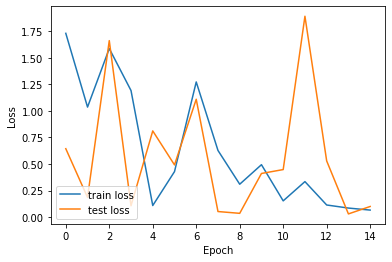

In [ ]:
plt.plot(m.epoch_loss_train, label = 'train loss')
plt.plot(m.epoch_loss_test, label = 'test loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='lower left')

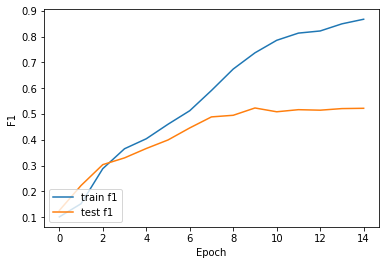

In [ ]:
plt.plot(m.epoch_f1_train, label = 'train f1')
plt.plot(m.epoch_f1_test, label = 'test f1')
plt.xlabel('Epoch')
plt.ylabel('F1')
plt.legend(loc='lower left')

In [200]:
m, f1, acc = run_experiments(15, RNNModel, 50, 2000)


Start of epoch 0
TRAIN: Loss =1.859, F1 =0.089, ACC = 0.379
TEST: Loss =0.951, F1 =0.059, ACC = 0.388

Start of epoch 1
TRAIN: Loss =1.434, F1 =0.113, ACC = 0.418
TEST: Loss =0.385, F1 =0.122, ACC = 0.424

Start of epoch 2
TRAIN: Loss =1.817, F1 =0.123, ACC = 0.438
TEST: Loss =2.613, F1 =0.123, ACC = 0.441

Start of epoch 3
TRAIN: Loss =1.548, F1 =0.132, ACC = 0.451
TEST: Loss =0.461, F1 =0.126, ACC = 0.452

Start of epoch 4
TRAIN: Loss =1.011, F1 =0.130, ACC = 0.458
TEST: Loss =1.461, F1 =0.119, ACC = 0.459

Start of epoch 5
TRAIN: Loss =1.510, F1 =0.130, ACC = 0.462
TEST: Loss =1.068, F1 =0.128, ACC = 0.463

Start of epoch 6
TRAIN: Loss =1.901, F1 =0.136, ACC = 0.467
TEST: Loss =0.851, F1 =0.132, ACC = 0.468

Start of epoch 7
TRAIN: Loss =1.255, F1 =0.140, ACC = 0.472
TEST: Loss =1.978, F1 =0.135, ACC = 0.472

Start of epoch 8
TRAIN: Loss =1.376, F1 =0.147, ACC = 0.475
TEST: Loss =1.197, F1 =0.131, ACC = 0.475

Start of epoch 9
TRAIN: Loss =0.819, F1 =0.146, ACC = 0.478
TEST: Loss =

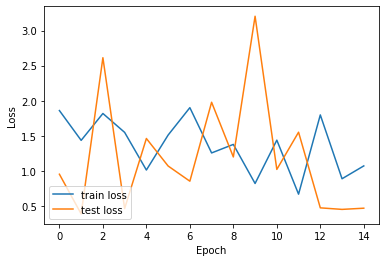

In [201]:
plt.plot(m.epoch_loss_train, label = 'train loss')
plt.plot(m.epoch_loss_test, label = 'test loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='lower left')

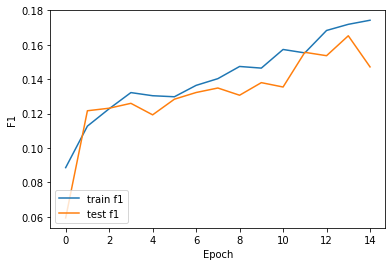

In [202]:
plt.plot(m.epoch_f1_train, label = 'train f1')
plt.plot(m.epoch_f1_test, label = 'test f1')
plt.xlabel('Epoch')
plt.ylabel('F1')
plt.legend(loc='lower left')

**Podsumowanie**

**Wyniki**

**Sieć RNN**

- FScore podczas eksperymentów osiągał maksymalnie 25%
- Eksperyment przeprowadzony na takich samych parametrach jak LSTM - FScore = 15%

**Sieć LSTM**

- Najlepszy osiągnięty FScore dla optymalnych parametrów = 52%
- Najlepsze znalezione parametry liczba epok = 15, liczba słów = 2000, dł wektora = 50

**Wpływ długości słownika**

- Testowane długości : [500, 1000, 2000]
- Wyniki na testowanych dlugościach są bardzo podobne
- Zmniejszając liczbę słów powinno się odpowiednio zmniejszać liczbę epok, by nie doszło do przeuczenia
- Długości < 500 sprawdzały się słabo

**Wnioski ogólne**

- accuracy nie jest dobrą miarą w przypadku tego zbioru
- wyniki LSTM są znacząco lepsze
- uczenie LSTM trwa dłużej